In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm, gamma
import seaborn as sns
sns.set(font='IPAexGothic')
import japanize_matplotlib

In [3]:
df = pd.read_csv("Davis.csv", index_col=0, header=0)
df

,sex,weight,height,repwt,repht
1,M,77,182,77.0,180.0
2,F,58,161,51.0,159.0
3,F,53,161,54.0,158.0
4,M,68,177,70.0,175.0
5,F,59,157,59.0,155.0
...,...,...,...,...,...
196,M,74,175,71.0,175.0
197,M,83,180,80.0,180.0
198,M,81,175,NaN,NaN
199,M,90,181,91.0,178.0


In [4]:
plt.style.use("ggplot")

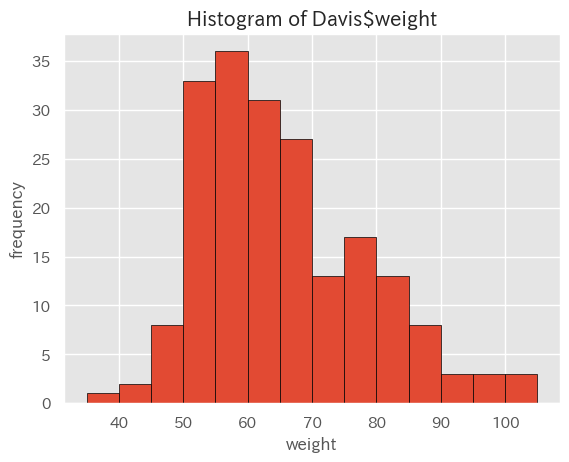

In [5]:
# ===== 実行例2.1: ヒストグラム =====
plt.hist(df["weight"], bins=14, range=(35, 105), edgecolor="black")
plt.xlabel("weight")
plt.ylabel("frequency")
plt.title("Histogram of Davis$weight")
plt.show()

In [6]:
# ===== 実行例2.2: 標本平均・標本分散 =====
mu = df["weight"].mean()          # 標本平均
s2 = ((df["weight"] - mu)**2).mean()  # 標本分散
print("mean:", mu)
print("variance:", s2)

mean: 65.8
variance: 226.72


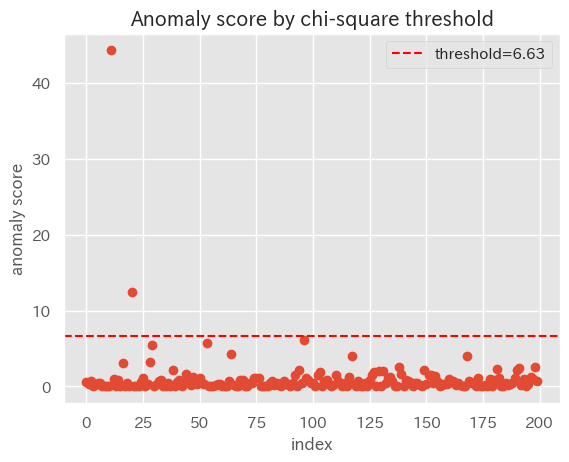

In [7]:
# ===== 実行例2.3: 異常度と閾値 =====
a = (df["weight"] - mu)**2 / s2   # 異常度
th = chi2.ppf(0.99, df=1)         # カイ二乗分布による1%水準の閾値

plt.plot(a.values, marker="o", linestyle="none")
plt.axhline(y=th, color="red", linestyle="--", label=f"threshold={th:.2f}")
plt.xlabel("index")
plt.ylabel("anomaly score")
plt.title("Anomaly score by chi-square threshold")
plt.legend()
plt.show()

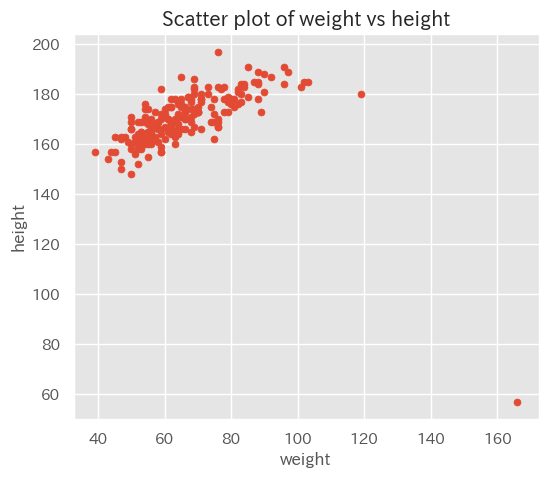

In [8]:
# ===== 実行例 2.4: 散布図 =====
X = df[["weight", "height"]].astype(float).to_numpy()
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], s=25)
plt.xlabel("weight")
plt.ylabel("height")
plt.title("Scatter plot of weight vs height")
plt.show()

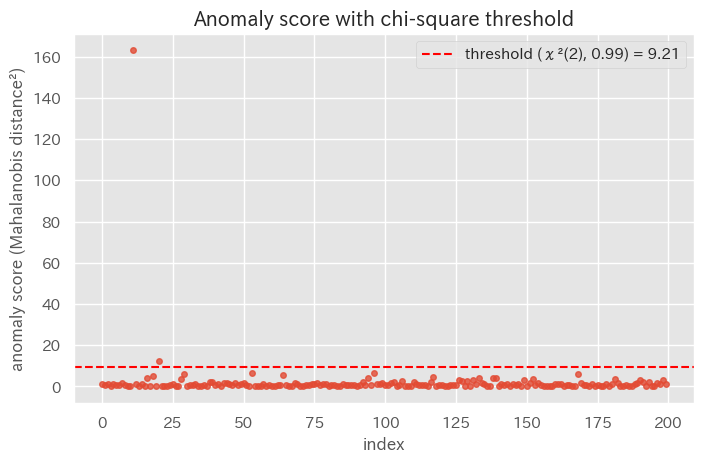

In [9]:
# ===== 実行例 2.5: 標本平均・中心化・共分散・異常度（マハラノビス距離^2） =====
# 標本平均（列平均）
mx = X.mean(axis=0)  # shape (2,)
# 中心化
Xc = X - mx          # shape (n, 2)
# 標本共分散行列（Rコードに合わせて 1/n で割る）
Sx = (Xc.T @ Xc) / Xc.shape[0]    # shape (2, 2)
# 逆行列
Sx_inv = np.linalg.inv(Sx)

# 異常度 a_i = (x_i - μ)^T S^{-1} (x_i - μ)  （マハラノビス距離の二乗）
# einsumで各行の二次形式をまとめて計算
a = np.einsum('ij,jk,ik->i', Xc, Sx_inv, Xc)

# 閾値：2変量なので自由度 df=2 のカイ二乗の 99%点
th = chi2.ppf(0.99, df=2)

# プロット
plt.figure(figsize=(8, 4.8))
plt.plot(a, "o", ms=4, alpha=0.8)
plt.axhline(th, color="red", linestyle="--", label=f"threshold (χ²(2), 0.99) = {th:.2f}")
plt.xlabel("index")
plt.ylabel("anomaly score (Mahalanobis distance²)")
plt.title("Anomaly score with chi-square threshold")
plt.legend()
plt.show()

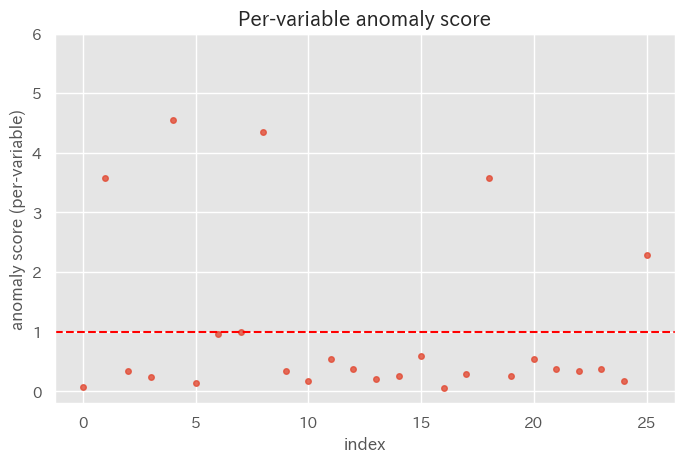

In [10]:
# ====== Rで保存した road.csv を読み込み ======
# Rの write.csv() は行名を1列目に出力するため、index_col=0 で読み込みます
df = pd.read_csv("road.csv", index_col=0)

# ====== 実行例2.6 の再現 ======
# X <- road / road$drivers
X = df.div(df['drivers'], axis=0)

# X <- as.matrix(log(X[,-2] + 1))
# （drivers列を除いてlog(・+1)を取る）
ordered = ['deaths', 'drivers', 'popden', 'rural', 'temp', 'fuel']
ordered = [c for c in ordered if c in X.columns]
X = X[ordered]
X = np.log(X.drop(columns=['drivers']) + 1).to_numpy()  # shape (n, p)

n, p = X.shape

# mx <- colMeans(X)
mx = X.mean(axis=0)

# Xc <- X - 1 * mx
Xc = X - mx

# Sx <- t(Xc) %*% Xc / nrow(X)
Sx = (Xc.T @ Xc) / n

# a <- rowSums((Xc %*% solve(Sx)) * Xc) / ncol(X)
Sx_inv = np.linalg.inv(Sx)
a = np.einsum('ij,jk,ik->i', Xc, Sx_inv, Xc) / p

# プロット：ylim=c(-1, 30)/p、y=1に破線
plt.style.use("ggplot")  # ggplot風スタイル
plt.figure(figsize=(8, 4.8))
plt.plot(a, "o", ms=4, alpha=0.8)
plt.axhline(1.0, linestyle="--", color="red")
plt.xlabel("index")
plt.ylabel("anomaly score (per-variable)")
plt.ylim((-1)/p, 30/p)
plt.title("Per-variable anomaly score")
plt.show()

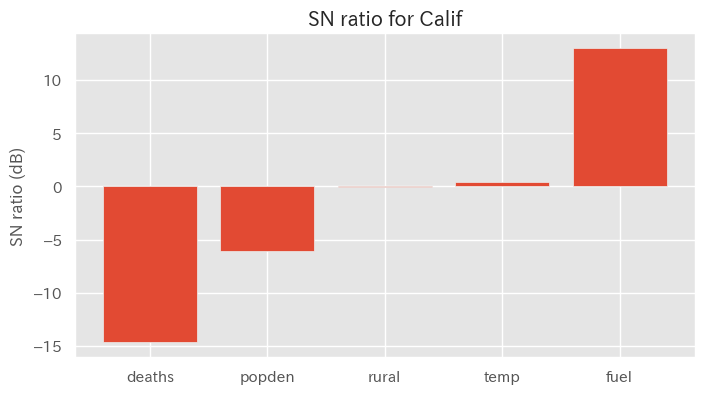

In [11]:
# ====== 実行例2.7 の再現 ======
# xc_prime <- Xc["Calif",]
index_labels = list(df.index)
target = None
for cand in ['Calif', 'California', 'CA']:
    if cand in index_labels:
        target = cand
        break
if target is None:
    target = index_labels[0]  # 見つからなければ最初の州を使用

# 対応する行番号を取得
row_pos = index_labels.index(target)
xc_prime = Xc[row_pos, :]  # shape (p,)

# SN1 <- 10*log10(xc_prime^2/diag(Sx))
SN1 = 10 * np.log10((xc_prime**2) / np.diag(Sx))

# 棒グラフ（Rのbarplot相当）
labels = [c for c in df.columns if c != 'drivers']
plt.figure(figsize=(8, 4.2))
plt.bar(range(p), SN1)
plt.xticks(range(p), labels, rotation=0)
plt.ylabel("SN ratio (dB)")
plt.title(f"SN ratio for {target}")
plt.show()

In [12]:
# ====== Davisデータの読み込み ======
df = pd.read_csv("Davis.csv", index_col=0)
weight = df["weight"].astype(float).to_numpy()

# ====== 実行例3.1: モーメント法 & 最尤法 ======
N = len(weight)                    # 標本数
mu = weight.mean()                 # 標本平均

# Rのsd()は分母(n-1) -> si は母標準偏差に変換: sd * sqrt((N-1)/N)
sd_sample = weight.std(ddof=1)
si = sd_sample * np.sqrt((N - 1) / N)

# モーメント法 (k, s)  ここで s は scale(=θ)
kmo = (mu / si) ** 2              # k = (μ/σ)^2
smo = (si ** 2) / mu              # s = σ^2 / μ

# 最尤法 (scipyのGammaは shape=a, loc, scale=θ)
# Rの"MASS::fitdistr(..., 'gamma')"はloc=0のガンマ（rate推定）に相当するので floc=0 で合わせます
kml, loc_mle, sml = gamma.fit(weight, floc=0)  # k=shape, loc=0, s=scale(=θ)
# Rのsmlは 1/rate なので、scipyの scale がそのまま s(=θ) に対応

print("MoM estimates: kmo, smo =", kmo, smo)
print("MLE estimates: kml, sml =", kml, sml)

MoM estimates: kmo, smo = 19.096859562455897 3.445592705167173
MLE estimates: kml, sml = 22.48530359200564 2.926355863097812


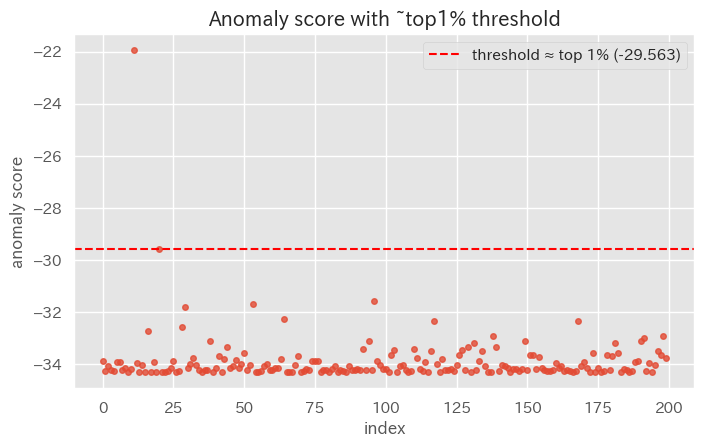

In [13]:
# ====== 実行例3.2: 異常度としきい値（上位1%） ======
# a = x/smo - (kmo - 1) * log(x/smo)
a = weight / smo - (kmo - 1) * np.log(weight / smo)

# Rの: th <- order(a, decreasing = T)[0.01*N]
# → 降順に並べたときの「上位1%番目」の値をしきい値にするイメージ
a_sorted_desc = np.sort(a)[::-1]
idx = int(np.floor(0.01 * N)) - 1   # Rは1始まり, Pythonは0始まり
if idx < 0:
    idx = 0
th_val = a_sorted_desc[idx]

plt.style.use("ggplot")  # ggplot風スタイル
plt.figure(figsize=(8, 4.6))
plt.plot(a, "o", ms=4, alpha=0.8)
plt.axhline(th_val, color="red", linestyle="--", label=f"threshold ≈ top 1% ({th_val:.3f})")
plt.xlabel("index")
plt.ylabel("anomaly score")
plt.title("Anomaly score with ~top1% threshold")
plt.legend()
plt.show()

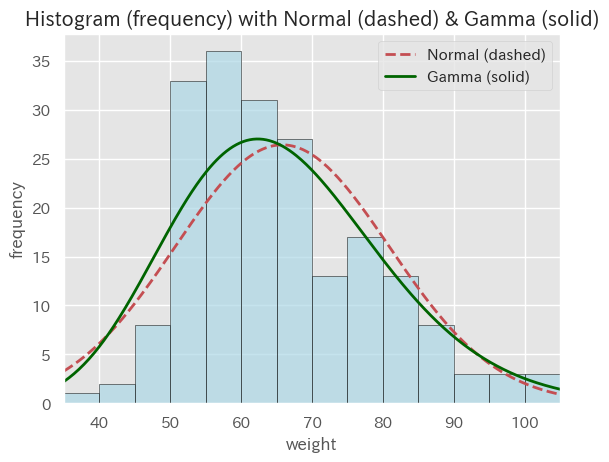

In [14]:
# ====== ヒストグラム（度数）と理論曲線（度数スケール） ======
# Rの var() は分母(n-1)なので、ここも ddof=1 で合わせます
s2 = weight.var(ddof=1)
sigma = np.sqrt(s2)
n = N

# ヒストグラム（度数）
counts, bins, patches = plt.hist(
    weight, bins=14, range=(35, 105),
    color="lightblue", edgecolor="black", alpha=0.7
)
bin_width = bins[1] - bins[0]

# x軸（理論曲線用）
x = np.linspace(35, 105, 300)

# 正規分布（破線, 度数スケールに換算：density × n × bin_width）
y_norm = norm.pdf(x, loc=mu, scale=sigma) * n * bin_width
plt.plot(x, y_norm, "r--", linewidth=2, label="Normal (dashed)")

# ガンマ分布（実線, モーメント法の shape/scale でRの式を再現）
shape_mom = mu**2 / s2   # Rコードの shape <- mu^2 / s2 （s2は分母n-1の分散）
scale_mom = s2 / mu
y_gamma = gamma.pdf(x, a=shape_mom, scale=scale_mom) * n * bin_width
plt.plot(x, y_gamma, color="darkgreen", linewidth=2, label="Gamma (solid)")

plt.xlim(35, 105)
plt.xlabel("weight")
plt.ylabel("frequency")
plt.title("Histogram (frequency) with Normal (dashed) & Gamma (solid)")
plt.legend()
plt.show()